In [1]:
# Zdefiniowanie struktury
struct Dual{T <:Number} <:Number
     v::T
    dv::T
end
#struct Dual <:Number
#     v::Number
#    dv::Number
#end

In [2]:
# Przeciążenie podstawowych operatorów
import Base: +, -, *, /
-(x::Dual)          = Dual(-x.v,       -x.dv)
+(x::Dual, y::Dual) = Dual( x.v + y.v,  x.dv + y.dv)
-(x::Dual, y::Dual) = Dual( x.v - y.v,  x.dv - y.dv)
*(x::Dual, y::Dual) = Dual( x.v * y.v,  x.dv * y.v + x.v * y.dv)
/(x::Dual, y::Dual) = Dual( x.v / y.v, (x.dv * y.v - x.v * y.dv)/y.v^2)
# Przeciążenie podstawowych funkcji
import Base: abs, sin, cos, tan, exp,log, sqrt, isless
abs(x::Dual)  = Dual(abs(x.v),sign(x.v)*x.dv)
sin(x::Dual)  = Dual(sin(x.v), cos(x.v)*x.dv)
cos(x::Dual)  = Dual(cos(x.v),-sin(x.v)*x.dv)
tan(x::Dual)  = Dual(tan(x.v), one(x.v)*x.dv + tan(x.v)^2*x.dv)
exp(x::Dual)  = Dual(exp(x.v), exp(x.v)*x.dv)
log(x::Dual)  = Dual(log(x.v), x.dv/x.v)
sqrt(x::Dual) = Dual(sqrt(x.v),.5/sqrt(x.v) * x.dv)
isless(x::Dual, y::Dual) = x.v < y.v;

In [3]:
# Promocja typów i konwersja
import Base: convert, promote_rule

In [4]:
#convert(::Type{Dual}, x::T) where T<:Real = Dual(x, zero(x))
#promote_rule(::Type{Dual}, ::Type{T}) where T<:Real = Dual

In [5]:
convert(::Type{Dual{T}}, x::Dual) where T = Dual(convert(T, x.v), convert(T, x.dv))
@show Dual{Float64}[Dual(1,2), Dual(3,0)];

Dual{Float64}[Dual(1, 2), Dual(3, 0)] = Dual{Float64}[Dual{Float64}(1.0, 2.0), Dual{Float64}(3.0, 0.0)]


In [6]:
convert(::Type{Dual{T}}, x::Number) where T = Dual(convert(T, x), zero(T))
@show Dual{Float64}[1, 2, 3];

Dual{Float64}[1, 2, 3] = Dual{Float64}[Dual{Float64}(1.0, 0.0), Dual{Float64}(2.0, 0.0), Dual{Float64}(3.0, 0.0)]


In [7]:
promote_rule(::Type{Dual{T}}, ::Type{R}) where {T,R} = Dual{promote_type(T,R)}
@show Dual(1,2) * 3;

Dual(1, 2) * 3 = Dual{Int64}(3, 6)


In [8]:
# Pomocne funkcje
import Base: show
show(io::IO, x::Dual) = print(io, "(", x.v, ") + [", x.dv, "ϵ]");
value(x::Dual) = x.v;
partials(x::Dual) = x.dv;

In [9]:
ReLU(x) = max(zero(x), x)
σ(x) = one(x) / (one(x) + exp(-x))
tanh(x) = 2.0 / (one(x) + exp(-2.0x)) - one(x)
linear(x) = x
f(x) = x > zero(x) ? x : zero(x)
ϵ = Dual(0., 1.)

x = -1.0:0.05:+1.0
y = partials.(f.(x .+ ϵ));

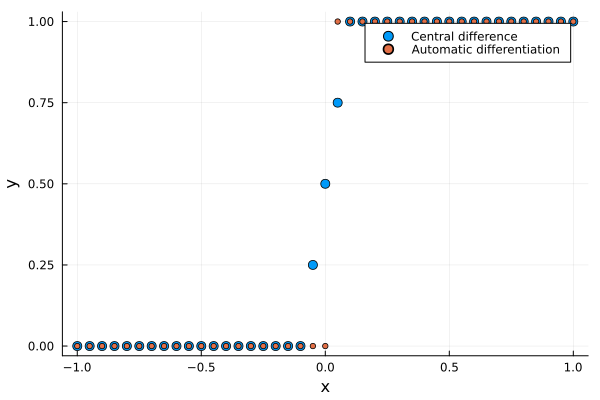

In [10]:
center_diff(f, x₀; Δx=1e-3) = ( f(x₀ + Δx) - f(x₀ - Δx) )/2Δx
ŷ = center_diff.(ReLU, x; Δx=1e-1)
using Plots
plot(x,  ŷ, line=nothing, marker=:circle, markersize=5., label="Central difference")
plot!(x, y, line=nothing, marker=:circle, markersize=3., label="Automatic differentiation")
xaxis!("x")
yaxis!("y")

In [11]:
D = derivative(f, x) = partials(f(Dual(x, one(x))))

derivative (generic function with 1 method)

In [13]:
J = function jacobian(f, args::Vector{T}) where {T <:Number}
    jacobian_columns = Matrix{T}[]
    for i=1:length(args)
        x = Dual{T}[]
        for j=1:length(args)
            seed = (i == j)
            push!(x, seed ?
                Dual(args[j], one(args[j])) :
                Dual(args[j],zero(args[j])) )
        end
        column = partials.([f(x)...])
        push!(jacobian_columns, column[:,:])
    end
    hcat(jacobian_columns...)
end

jacobian (generic function with 1 method)

In [14]:
n = 5.2
@show [n...];
v = [3.1,3.3]
@show [v...];
@show typeof(v);
@show typeof(v[:,:]);

[n...] = [5.2]
[v...] = [3.1, 3.3]
typeof(v) = Vector{Float64}
typeof(v[:, :]) = Matrix{Float64}


In [15]:
H = function hessian(f, args::Vector)
    ∇f(x::Vector) = J(f, x)
    J(∇f, args)
end

hessian (generic function with 1 method)

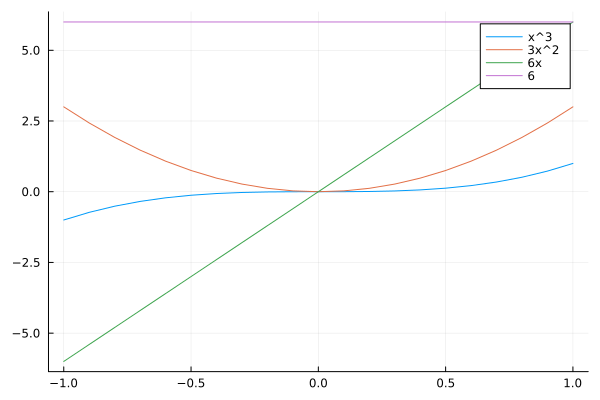

In [20]:
f(x) = x^3
f′(x) = derivative(f,  x)
f″(x) = derivative(f′, x)
f‴(x) = derivative(f″, x)
x = -1:0.1:+1

using Plots
plot(x,  f.(x),  label="x^3")
plot!(x, f′.(x), label="3x^2")
plot!(x, f″.(x), label="6x")
plot!(x, f‴.(x), label="6")

Działa dla funkcji jednej zmiennych, a czy na wielu zmiennych?

In [16]:
f(x::Vector) = sum(sin, x) + prod(tan, x) * sum(sqrt, x);
H(f, [0.986403, 0.140913, 0.294963, 0.837125, 0.650451])

5×5 Matrix{Float64}:
 0.585108  3.48082  1.7706    0.994056  1.03257
 3.48082   1.06079  5.79298   3.25244   3.3787
 1.7706    5.79298  0.423982  1.65416   1.71818
 0.994056  3.25244  1.65416   0.251395  0.964565
 1.03257   3.3787   1.71818   0.964565  0.140688

In [17]:
f(x::Vector) = x[1]^3 + x[1]*x[2]
H(f, [1., 2.])

2×2 Matrix{Float64}:
 6.0  1.0
 1.0  0.0

In [18]:
f(x::Vector) = sum(x.^2)
H(f, [1, 2, 3])

3×3 Matrix{Int64}:
 2  0  0
 0  2  0
 0  0  2

Teraz sprawdzimy, czy działa liczenie jakobianu funkcji wektorowej:

In [19]:
f(x::Vector) = [2x[1]*x[2], 3x[2]*x[3]]
J(f, [1, 2., 3, 4, 5])

2×5 Matrix{Float64}:
 4.0  2.0  0.0  0.0  0.0
 0.0  9.0  6.0  0.0  0.0

Należy uważać na pomieszanie się $\epsilon$:

In [20]:
D(x -> x*D(y -> x+y, 1), 1) # == 1

2

Powyższy wynik jest niepoprawny, bo `x` z zewnętrznego domknięcia jest typu `Dual`:

In [21]:
D(x -> x*D(y -> value(x) + y, 1), 9999) # == 1

1

Drugi przykład kodu, który nie robi tego, co byśmy chcieli:

In [22]:
D(x -> x*D(y -> x*y, 1), 4) # == 8

5

In [23]:
f(x::Vector) = x[1]*x[2]
j(x::Vector) = x[1]*J(f, x)
h(x::Vector) = J(j, x)
h([4., 1.])[2,1]

8.0

Dzięki temu możemy liczyć różniczki bardziej zaawansowanych funkcji, np. funkcję aktywacji SoftMax:

In [24]:
import LinearAlgebra: diagm
diagonal(m) = diagm(0 => vec(m))

softmax(x)  =  exp.(x) ./ sum(exp.(x));
dsoftmax(x) = (softmax(x) |> diagonal) .- softmax(x) * (softmax(x) |> transpose);

In [25]:
J(softmax, [0.1, 0.3, 0.99])

3×3 Matrix{Float64}:
  0.168634   -0.0563292  -0.112304
 -0.0563292   0.193498   -0.137169
 -0.112304   -0.137169    0.249473

In [26]:
dsoftmax([0.1, 0.3, 0.99])

3×3 Matrix{Float64}:
  0.168634   -0.0563292  -0.112304
 -0.0563292   0.193498   -0.137169
 -0.112304   -0.137169    0.249473

In [27]:
cross_entropy_loss(y, ŷ) = sum(-y .* log.(ŷ))
J(ŷ -> cross_entropy_loss([0.0, 1.0, 0.0], ŷ), [0.1, 0.3, 0.99])

1×3 Matrix{Float64}:
 -0.0  -3.33333  -0.0

In [28]:
dcross_entropy_loss(y, ŷ) = -y ./ ŷ
dcross_entropy_loss([0.0, 1.0, 0.0], [0.1, 0.3, 0.99])

3-element Vector{Float64}:
 -0.0
 -3.3333333333333335
 -0.0

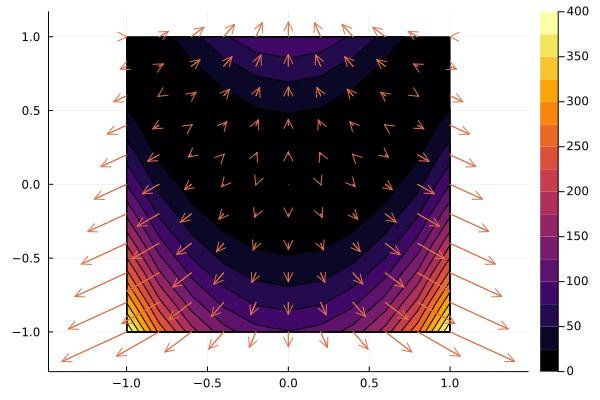

In [29]:
rosenbrock(x, y) = (1.0 - x*x) + 100.0*(y - x*x)*(y - x*x)

v  = -1:.2:+1
n  = length(v)
xv = repeat(v, inner=n)
yv = repeat(v, outer=n)

z  = rosenbrock.(xv .+ ϵ, yv)
dx = 5e-4partials.(z)
z  = rosenbrock.(xv, yv .+ ϵ)
dy = 5e-4partials.(z)
zv = value.(z)

using Plots
zv = reshape(zv, n, n)
contour(v, v, zv, fill=true)
quiver!(xv[:], yv[:], gradient=(dx, dy))

# No i jesteśmy w stanie nauczyć prostą sieć neuronową!

In [35]:
mean_squared_loss(y::Vector, ŷ::Vector) = sum(0.5(y - ŷ).^2)
fullyconnected(w::Vector, n::Number, m::Number, v::Vector, activation::Function) = activation.(reshape(w, n, m) * v)
Wh  = randn(10,2)
Wo  = randn(1,10)
dWh = similar(Wh)
dWo = similar(Wo)
x = [1.98;4.434]
y = [0.064]
E = Float64[]

function net(x, wh, wo, y)
    x̂ = fullyconnected(wh, 10, 2, x, σ)
    ŷ = fullyconnected(wo, 1, 10, x̂, linear)
    E = mean_squared_loss(y, ŷ)
end

dnet_Wh(x, wh, wo, y) = J(w -> net(x, w, wo, y), wh);
dnet_Wo(x, wh, wo, y) = J(w -> net(x, wh, w, y), wo);

Ei     =  net(x, Wh[:], Wo[:], y)

0.06944521390613796

Poniżej zaimplementowana metoda najszybszego spadku: 
gradienty `dWh` i `dWo` wskazują gradienty, czyli kierunki
najszybszego **wzrostu** wartości funkcji błędu

In [36]:
push!(E, Ei)
dWh[:] = dnet_Wh(x, Wh[:], Wo[:], y);
dWo[:] = dnet_Wo(x, Wh[:], Wo[:], y);
Wh -= 0.1dWh
Wo -= 0.1dWo

Ei     =  net(x, Wh[:], Wo[:], y)

0.053648988580552046

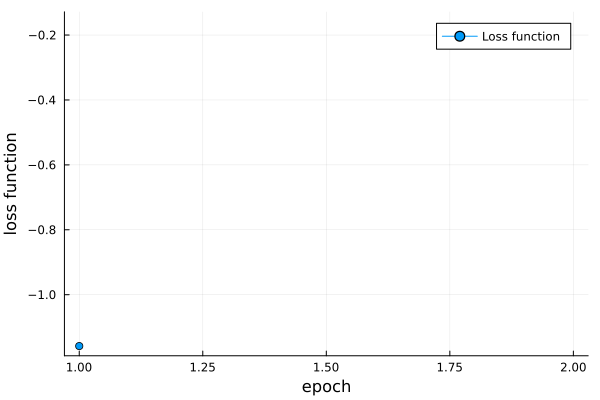

In [37]:
plot(log10.(E), label="Loss function", marker=:circle)
xaxis!("epoch")
yaxis!("loss function")

In [38]:
f(x,y) = x*x*y
dfdx(x, y) = 2x*y
dfdy(x, y) = x*x

ϵ = Dual(0., 1.);
x = 1.0 + ϵ
y = 3.0
@show f(x,y), dfdx(1.0, 3.0);

(f(x, y), dfdx(1.0, 3.0)) = ((3.0) + [6.0ϵ], 6.0)


In [39]:
x = 1.0
y = 3.0 + ϵ
@show f(x,y), dfdy(1.0,3.0)

(f(x, y), dfdy(1.0, 3.0)) = ((3.0) + [1.0ϵ], 1.0)


((3.0) + [1.0ϵ], 1.0)

In [40]:
x = 5.0 + Dual(0., 1.)

(5.0) + [1.0ϵ]

In [41]:
 Dual( sin(25.0),  cos(25.0) * 10.0 )

(-0.13235175009777303) + [9.912028118634735ϵ]

In [42]:
 Dual( sin(25.0),  cos(25.0) * 10.0 )

(-0.13235175009777303) + [9.912028118634735ϵ]

In [43]:
function tryme(x)
    if x < 4one(x)
        9one(x)
    else
        x
    end
end
tryme(3. + Dual(0., 1.))

(9.0) + [0.0ϵ]

In [44]:
ϵ = Dual(0., 1.)
A = Dual{Float64}[1 2; 3+ϵ 4]
m = maximum(A)

(4.0) + [0.0ϵ]